In [ ]:
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

import time
import datetime

import json

SEED = 42
def seed_everything(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)  # type: ignore
  torch.backends.cudnn.deterministic = True  # type: ignore
  torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(seed = SEED)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MakingDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    image = self.X[index]
    label = self.y[index]
    return image, label

  def __len__(self):
      return len(self.y)


class TrainTestLoader(object):
  def __init__(self, data_type="MNIST"):
    self.data = data_type

    self.training_data=None
    self.test_data=None

    self.train_X = None
    self.train_y = None
    self.test_X = None
    self.test_y = None

    if self.data == "MNIST":
      download_root = "./MNIST_DATASET"
      MNIST_transform = transforms.Compose([
                    transforms.ToTensor()
                  ])
      self.training_data = MNIST(download_root,
                        train=True,
                        download=True,
                        transform=MNIST_transform)

      self.test_data = MNIST(download_root,
                        train=False,
                        download=True,
                        transform=MNIST_transform)

      train_X = self.training_data.data / 255.0
      train_y = self.training_data.targets

      test_X = self.test_data.data / 255.0
      test_y = self.test_data.targets

      # 0과 1에 해당하는 데이터만 추출
      self.train_X = train_X[(train_y==0) | (train_y==1)]
      self.train_y = train_y[(train_y==0) | (train_y==1)]
      self.test_X = test_X[(test_y==0) | (test_y==1)][:1000]
      self.test_y = test_y[(test_y==0) | (test_y==1)][:1000]


  def scale_pca(self, size):
    if self.data == "MNIST":
      train_shape = self.train_X.shape
      test_shape = self.test_X.shape
      train_X = self.train_X.reshape((train_shape[0],
                                      train_shape[1]*train_shape[2]))
      test_X = self.test_X.reshape((test_shape[0],
                                      test_shape[1]*test_shape[2]))

    # ###여기에 standardscaler 있었는데 그냥 안 함
    #   from sklearn.preprocessing import StandardScaler
    #   scaler = StandardScaler()
    #   train_X = scaler.fit_transform(train_X)
    #   test_X = scaler.transform(test_X)

      pca = PCA(n_components = size)
      train_X = pca.fit_transform(train_X)
      test_X = pca.transform(test_X)
      ####### 중요도가 높은 게 아래로 가게 변경#######
      train_X=train_X[:,::-1]
      test_X=test_X[:,::-1]
      self.train_X = torch.Tensor(train_X.copy())
      self.test_X = torch.Tensor(test_X.copy())

      if size <= 30:
        ### Rescale for angle embedding 원본
        self.train_X = torch.Tensor((train_X - train_X.min())\
                                    * (np.pi / (train_X.max() - train_X.min())))
        self.test_X = torch.Tensor((test_X - test_X.min())\
                                   * (np.pi / (test_X.max() - test_X.min())))


  def scale_resize(self, size):
    if self.data == "MNIST":
      size = int(np.sqrt(size))
      t = transforms.Resize(size=(size, size))
      train_X = t(self.train_X)
      test_X = t(self.test_X)

      self.train_X = train_X.reshape((train_X.shape[0],
                                     train_X.shape[1]*train_X.shape[2]))
      self.test_X = test_X.reshape((test_X.shape[0],
                                     test_X.shape[1]*test_X.shape[2]))

  def return_dataset(self):
      return MakingDataset(self.train_X, self.train_y), MakingDataset(self.test_X, self.test_y)

  # def save(self):
  #     self.training_data.to_csv("./training_data.csv", index = False)
  #     self.test_data.to_csv("./test_data.csv", index = False)

  # def load(self):
  #     self.training_data = read_csv("./training_data.csv")
  #     self.test_data = read_csv("./test_data.csv")



In [ ]:
# embedding_method
class EmbeddingMethod():
  def __init__(self, n_qubits = 8, embedding_type = "Amplitude"):
    self.n_qubits = n_qubits
    self.embedding_type = embedding_type
  
  def embed_data (self, inputs):
    if self.embedding_type == "Amplitude": # need (2^n_qubits) data
      qml.AmplitudeEmbedding(inputs, wires=range(self.n_qubits),
                           pad_with=0, normalize=True)
    
    elif embedding_type == 'Angle-compact':
      qml.AngleEmbedding(inputs[:8], wires=range(self.n_qubits), rotation='X')
      qml.AngleEmbedding(inputs[8:16], wires=range(self.n_qubits), rotation='Y')

    elif self.embedding_type == "HybridAngle_2":
      N = 3  # 3 classical bits in 2 qubits
      X1 = inputs[:N]
      X2 = inputs[N:2*N]
      X3 = inputs[2*N:3*N]
      X4 = inputs[3*N:4*N]
      self.Angular_Hybrid_2(X1, wires=[0,1])
      self.Angular_Hybrid_2(X2, wires=[2,3])
      self.Angular_Hybrid_2(X3, wires=[4,5])
      self.Angular_Hybrid_2(X4, wires=[6,7])

    elif self.embedding_type == "HybridAngle_4":
      N = 15 # 15 classical data in 4 qubits
      X1 = inputs[:N]
      X2 = inputs[N:2*N]
      self.Angular_Hybrid_4(X1, wires=[0, 1, 2, 3])
      self.Angular_Hybrid_4(X2, wires=[4, 5, 6, 7])


  # Hybrid Angle Embedding Method
  
  def Angular_Hybrid_2(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])
  
  def Angular_Hybrid_4(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])

    qml.RY(X[3], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[4], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.RY(X[5], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[6], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])

    qml.RY(X[7], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[8], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[9], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[10], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.RY(X[11], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[12], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[13], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[14], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])



In [ ]:
#QCNN_circuit

class QCNN():
  def __init__(self, n_qubits, embedding_type, conv_ansatz, pooling_ansatz):
    super(QCNN, self).__init__()
    self.n_qubits = n_qubits
    self.embedding_method = EmbeddingMethod(n_qubits = n_qubits,
                                            embedding_type = embedding_type)
    if conv_ansatz == "ConvCirc1":
      self.conv_ansatz = ConvCirc1()
    elif conv_ansatz == "ConvCircSU4":
      self.conv_ansatz = ConvCircSU4()

    if pooling_ansatz == "PoolingCirc":
      self.pooling_ansatz = PoolingCirc()

    # self.params = torch.rand(self.Calculate_Param_Num(),
    #                         requires_grad=True)
    self.params = torch.randn(self.Calculate_Param_Num(),
                            requires_grad=True)


  def circuit(self, params, inputs):
    
    self.embedding_method.embed_data(inputs)
    
    ansatz_param_num = self.conv_ansatz.num_params
    param1 = params[0:ansatz_param_num]
    param2 = params[ansatz_param_num: 2 * ansatz_param_num]
    param3 = params[2 * ansatz_param_num: 3 * ansatz_param_num]

    param4 = params[3 * ansatz_param_num: 3 * ansatz_param_num + 2]
    param5 = params[3 * ansatz_param_num + 2: 3 * ansatz_param_num + 4]
    param6 = params[3 * ansatz_param_num + 4: 3 * ansatz_param_num + 6]

    self.conv_layer1(param1)
    self.pooling_layer1(param4)

    self.conv_layer2(param2)
    self.pooling_layer2(param5)

    self.conv_layer3(param3)
    self.pooling_layer3(param6)
  

  # Convolutional layers
  def conv_layer1(self, params):
    for i in range(0, 8, 2):
        self.conv_ansatz.apply(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        self.conv_ansatz.apply(params, wires=[i, i + 1])
    self.conv_ansatz.apply(params, wires=[0, 7])

  def conv_layer2(self, params):
    self.conv_ansatz.apply(params, wires=[1, 3])
    self.conv_ansatz.apply(params, wires=[5, 7])
    self.conv_ansatz.apply(params, wires=[1, 7])
    self.conv_ansatz.apply(params, wires=[3, 5])

  def conv_layer3(self, params):
    self.conv_ansatz.apply(params, wires=[3,7])


  # Pooling layers
  def pooling_layer1(self, params):
      for i in range(0, 8, 2):
          self.pooling_ansatz.apply(params, wires=[i, i+1])

  def pooling_layer2(self, params):
      self.pooling_ansatz.apply(params, wires=[1,3])
      self.pooling_ansatz.apply(params, wires=[5,7])

  def pooling_layer3(self, params):
      self.pooling_ansatz.apply(params, wires=[7,3])


  def Calculate_Param_Num(self):
    ansatz_param = self.conv_ansatz.num_params
    pooling_param = self.pooling_ansatz.num_params
    total_param_num = ansatz_param*3 + pooling_param*3
    return total_param_num



In [ ]:
## ansatz 여기에서 추가 가능

# Convolutional Layer Ansatz
class ConvCirc1():
  def __init__(self) -> None:
    self.num_params = 2

  def apply(self, weights, wires):
    qml.RY(weights[0], wires = wires[0])
    qml.RY(weights[1], wires = wires[1])
    qml.CNOT(wires = wires)

# Convolutional Layer Ansatz SU(4)
class ConvCircSU4():
  def __init__(self) -> None:
      self.num_params = 15

  def apply(self, weights, wires):
      qml.U3(weights[0], weights[1], weights[2], wires = wires[0])
      qml.U3(weights[3], weights[4], weights[5], wires = wires[1])
      qml.CNOT(wires = [wires[0], wires[1]])
      qml.RY(weights[6], wires = wires[0])
      qml.RZ(weights[7], wires = wires[1])
      qml.CNOT(wires = [wires[1], wires[0]])
      qml.RY(weights[8], wires=wires[0])
      qml.CNOT(wires = [wires[0], wires[1]])
      qml.U3(weights[9], weights[10], weights[11], wires = wires[0])
      qml.U3(weights[12], weights[13], weights[14], wires = wires[1])

# Pooling Layer Ansatz
class PoolingCirc():
  def __init__(self) -> None:
      self.num_params = 2
  
  def apply(self, weights, wires):
      qml.CRY(weights[0], wires = wires)
      qml.PauliX(wires[0])
      qml.CRY(weights[1], wires = wires)
      qml.PauliX(wires[0])



In [ ]:
class Setting():
  def __init__(self, data_type="MNIST", n_qubits=8, embedding_type="Amplitude",
               scaling_method = "pca",
               scaled_dim = 256, EPOCHS = 3, train_iter = 200,
               BATCH_SIZE = 25, LEARNING_RATE = 0.01, VAL_SIZE = 1000,
               conv_ansatz="ConvCirc1", pooling_ansatz="PoolingCirc",
               cost_fn = "mse"):
    self.data_type=data_type
    self.n_qubits=n_qubits
    self.embedding_type = embedding_type
    self.scaling_method = scaling_method
    self.scaled_dim = scaled_dim
    self.EPOCHS = EPOCHS
    self.train_iter = train_iter
    self.BATCH_SIZE = BATCH_SIZE
    self.LEARNING_RATE = LEARNING_RATE
    self.VAL_SIZE = VAL_SIZE
    self.conv_ansatz=conv_ansatz
    self.pooling_ansatz=pooling_ansatz
    self.cost_fn = cost_fn
    if cost_fn == "mse":
      self.criterion = nn.MSELoss()
    elif cost_fn == "cross_entropy":
      self.criterion = nn.CrossEntropyLoss()

    loader = TrainTestLoader(data_type=data_type)
    if self.scaling_method == "pca":
      loader.scale_pca( size = scaled_dim)
    elif self.scaling_method == "resize":
      loader.scale_resize( size = scaled_dim )
    self.train_data, self.test_data = loader.return_dataset()
    # print data sizes
    print(f"Train set #: {len(self.train_data)}")
    # print(f"Validation set #: {len(validation_set)}")
    print(f"Test set #:  {len(self.test_data)}")

    #######################file path 필요하면 수정######################
    self.filepath = "/content/drive/MyDrive/박경덕교수님연구실/MY_QCNN_module_ver"+\
            f"/{scaling_method}_{embedding_type}_{conv_ansatz}_{cost_fn}_result"
    
    if os.path.exists(self.filepath) == False:
        os.makedirs(self.filepath)
    self.writer = SummaryWriter(log_dir=self.filepath)
  
  def make_model(self):
    return QCNN(n_qubits = self.n_qubits,
                embedding_type = self.embedding_type,
                conv_ansatz = self.conv_ansatz,
                pooling_ansatz = self.pooling_ansatz)

  def make_train_loader(self):
    return DataLoader(self.train_data, batch_size = self.BATCH_SIZE, shuffle=True)

  def make_test_loader(self):
    return DataLoader(self.test_data, batch_size = len(self.test_data), shuffle=False)




In [ ]:
class Trainer():
  def __init__(self, setting):
    self.setting = setting
    self.loss_list = []
    self.avg_vloss_list = []
    self.history_of_parameters = []
    self.total_time = None

  # iter mode
  def training_model(self, model, train_loader)->None:
    iter = 0
    optimizer = optim.Adam([model.params], lr = setting.LEARNING_RATE)
    start_t = time.time()
    for inputs, labels in train_loader:
      if iter == self.setting.train_iter:
        break
      ############수정###########
      inputs = inputs.to(torch.float64)
      ############수정###########
      if self.setting.cost_fn == "mse":
        labels = 2*labels.to(torch.float64) - 1 # label을 1과 -1로 변환
      elif self.setting.cost_fn == "cross_entropy":
        # 0은 [1,0]으로 1은 [0,1]로 변환
        labels = nn.functional.one_hot(labels).to(torch.float64)

      optimizer.zero_grad()
      loss = torch.tensor(0, dtype = torch.float64)
      for input, label in zip(inputs, labels):
        pred = estimated_label(model.params, input)
        loss += self.setting.criterion(pred, label) / len(labels)
      loss.backward()
      optimizer.step()
      self.loss_list.append(loss.item())
      self.setting.writer.add_scalar('training loss', loss.item(), iter)
      np.save(self.setting.filepath+'/'+f'iter{iter}', model.params.detach().numpy())
      if (iter+1)%10 == 0:
        print(f"Iteration {iter+1:>3} loss: {loss.item()}")
      iter += 1

    end_t = time.time()
    sec = end_t - start_t
    self.total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
    print(f"Training during {self.setting.train_iter} iterations finishes (taken time: {self.total_time}) ")


# epoch mode



In [ ]:
class Tester():
  def __init__(self, setting):
    self.setting = setting
    self.accuracy = 0
  
  def testing_model(self, model, test_loader)->None:
    with torch.no_grad():
      if self.setting.cost_fn == "mse":
        pred_label_arr = []
        true_label_arr = []
        for inputs, labels in test_loader:
          ############수정###########
          inputs=inputs.to(torch.float64)
          ############수정###########
          for input, label in zip(inputs, labels):
            pred = estimated_label(model.params,input).detach().numpy() > 0
            pred_label_arr.append(pred)
            true_label_arr.append(label.numpy())
        accuracy = sum(np.array(pred_label_arr)==\
                  np.array(true_label_arr))  /  len(true_label_arr)
        self.accuracy = accuracy.item()
        
      elif self.setting.cost_fn == "cross_entropy":
        acc=0
        for inputs, labels in test_loader:
          ############수정###########
          inputs=inputs.to(torch.float64)
          ############수정###########
          for input, label in zip(inputs, labels):
            pred = estimated_label(model.params,input)
            if pred[0] > pred[1]:
                pred_label = 0
            else:
                pred_label = 1
            if pred_label == label :
                acc = acc + 1
        self.accuracy = acc / len(self.setting.test_data)

      print(f"Test socre: {self.accuracy}")



In [ ]:
def saving_summary(setting, trainer, tester):
  with open(setting.filepath+"/"+"summary.json","w") as fp:
    json.dump(dict(
        loss = trainer.loss_list,
        total_time = trainer.total_time,
        accuracy = tester.accuracy
    ), fp = fp)



In [ ]:
########################## hyper param ##############################
data_type = "MNIST"
n_qubits = 8
#### "Amplitude" - 256, "Angle-compact"-16, "HybridAngle_2"-12, "HybridAngle_4"-30
embedding_type = "Angle-compact"
scaling_method = "pca"  #### "pca" or "resize" ####
scaled_dim = 16
EPOCHS = 3
train_iter = 200
BATCH_SIZE = 25
LEARNING_RATE = 0.01
VAL_SIZE = 1000

conv_ansatz = "ConvCircSU4"  #### "ConvCirc1", "ConvCircSU4"
pooling_ansatz = "PoolingCirc"
cost_fn = "cross_entropy"  #### "mse" or "cross_entropy"

########################## hyper param ##############################


setting = Setting(data_type=data_type,
                  n_qubits=n_qubits,
                  embedding_type = embedding_type,
                  scaling_method = scaling_method,
                  scaled_dim = scaled_dim,
                  EPOCHS = EPOCHS,
                  train_iter = train_iter,
                  BATCH_SIZE = BATCH_SIZE,
                  LEARNING_RATE = LEARNING_RATE,
                  VAL_SIZE = VAL_SIZE,
                  conv_ansatz=conv_ansatz,
                  pooling_ansatz=pooling_ansatz,
                  cost_fn = cost_fn)

train_loader = setting.make_train_loader()
test_loader = setting.make_test_loader()

model = setting.make_model()

dev = qml.device("default.qubit", wires=setting.n_qubits)
@qml.qnode(dev, interface="torch")
def qnode(params, inputs):
  model.circuit(params,inputs)
  if setting.cost_fn == "mse":
    return qml.expval(qml.PauliZ(3))
  elif setting.cost_fn == "cross_entropy":
    return qml.probs(wires=3)

def estimated_label(params, inputs):
  return qnode(params, inputs)


Train set #: 12665
Test set #:  1000


In [ ]:
start_t = time.time()
random_data = torch.rand(setting.scaled_dim )
print(f"result of 1 data: {qnode(model.params, random_data)}")
end_t = time.time()
sec = end_t - start_t
total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
print(total_time)

result of 1 data: tensor([0.4746, 0.5254], dtype=torch.float64, grad_fn=<SqueezeBackward0>)
0:00:00


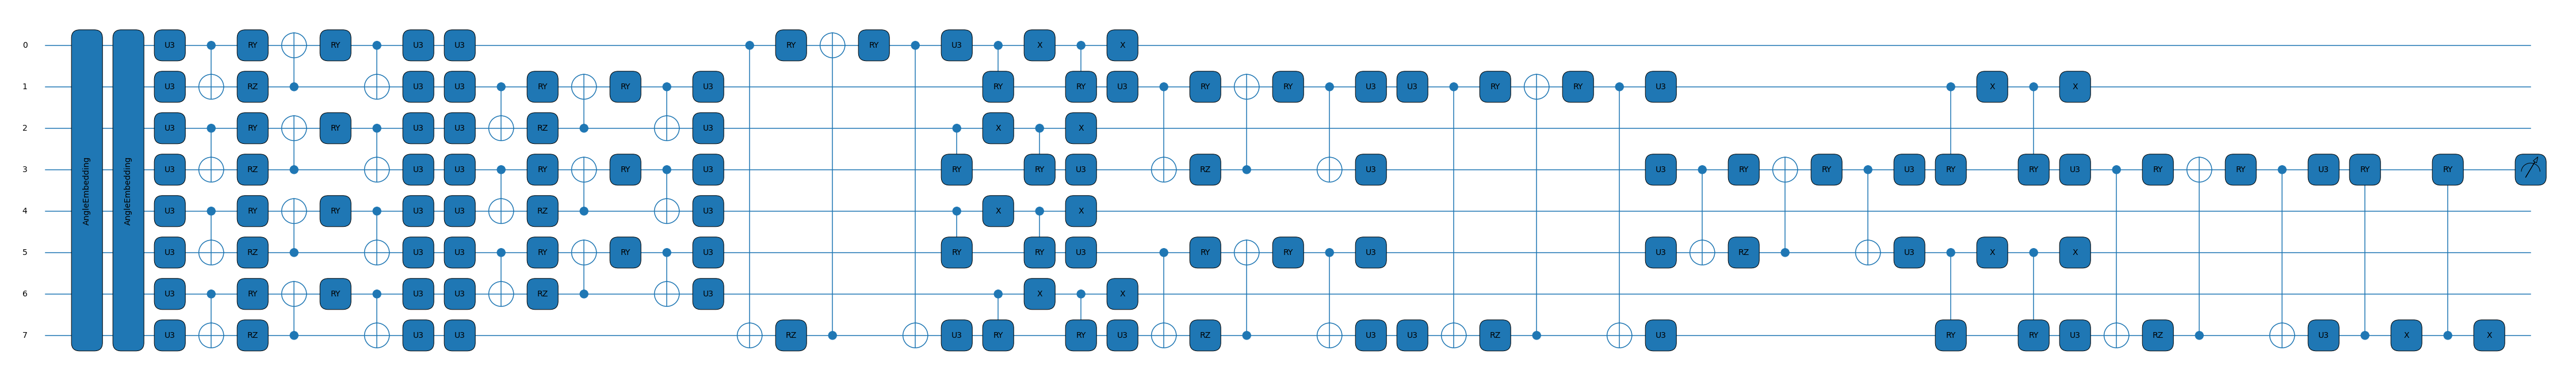

In [ ]:
data = torch.rand(scaled_dim)
fig, ax = qml.draw_mpl(qnode)(model.params,data)
plt.show()

In [ ]:
init_param = model.params
print( init_param )

tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
        -0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624,
         1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806,
         1.2791,  1.2964,  0.6105,  1.3347, -0.2316,  0.0418, -0.2516,  0.8599,
        -1.3847, -0.8712, -0.2234,  0.5258, -0.4880,  1.1914, -0.8140, -0.7360,
        -0.8371, -0.9224,  1.8113,  0.6756, -0.0978,  1.8446, -1.1845,  1.3835,
        -1.2024,  0.7078, -1.0759], requires_grad=True)


In [ ]:
############ train model ###########

trainer = Trainer(setting = setting)
trainer.training_model(model=model, train_loader=train_loader)


Iteration  10 loss: 0.6852476004500938
Iteration  20 loss: 0.6454361889748315
Iteration  30 loss: 0.6573064511469233
Iteration  40 loss: 0.6508297397733818
Iteration  50 loss: 0.6428683487844418
Iteration  60 loss: 0.629121372816754
Iteration  70 loss: 0.6526556090017074
Iteration  80 loss: 0.6397941731643062
Iteration  90 loss: 0.6461915713054307
Iteration 100 loss: 0.6617426612776767
Iteration 110 loss: 0.6314492461448659
Iteration 120 loss: 0.6309844242467897
Iteration 130 loss: 0.6397229620446064
Iteration 140 loss: 0.622670718193151
Iteration 150 loss: 0.5940431792003701
Iteration 160 loss: 0.5959748831837417
Iteration 170 loss: 0.603089042292276
Iteration 180 loss: 0.6333375230983322
Iteration 190 loss: 0.5668925948630215
Iteration 200 loss: 0.6032222796421003
Training during 200 iterations finishes (taken time: 0:14:49) 


In [ ]:
after_param = model.params
print( after_param )

tensor([ 1.5979,  0.7816,  0.7757, -1.8842,  0.3658, -1.0860, -0.1850, -0.7717,
        -0.0923,  1.4810, -1.1656, -1.3990, -0.6246, -0.3984, -0.7839,  1.1488,
         1.3527, -0.0813, -0.6657,  0.1998, -0.7563,  0.9951,  1.2155,  1.4602,
         1.6898,  1.8469,  0.5561,  1.7338, -0.2380, -0.0344,  0.1688,  0.5681,
        -1.6420, -1.2354, -0.6047,  0.3627, -0.2339,  1.1533, -1.0346, -0.6044,
        -0.8053, -0.7893,  1.7964,  0.6567,  0.2126,  1.1643, -1.2872,  1.6997,
        -1.6086,  0.2891, -0.6068], requires_grad=True)


In [ ]:
############# test model ###############

tester = Tester(setting = setting)
tester.testing_model(model, test_loader)

Test socre: 0.814


In [ ]:
saving_summary(setting, trainer, tester)

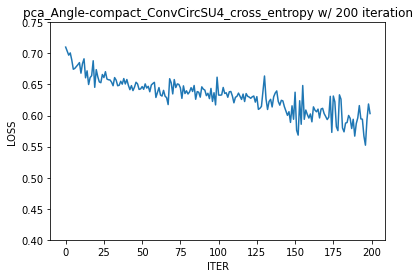

In [ ]:
############### loss plot ################

# loss_list
plt.plot(trainer.loss_list)
plot_title = "_".join(setting.filepath.split("/")[-1].split("_")[:-1])
plt.title(f"{plot_title} w/ {str(setting.train_iter)} iteration")
plt.xlabel("ITER")
plt.ylabel("LOSS")
plt.ylim((0.4, 0.75))

plt.show()


In [ ]:
plot_title

'pca_Angle-compact_ConvCircSU4_cross_entropy'

In [ ]:
####### tensorboard 실행 #######
!tensorboard --logdir=filepath+"/"